# Cosmic-ray flux vs. sky position

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2018-07-30 

CPython 2.7.13
IPython 5.7.0

numpy 1.14.5
scipy 1.1.0
pandas 0.23.1
sklearn 0.19.1
mlxtend 0.12.0


In [2]:
%load_ext autoreload
%autoreload 2

In [130]:
from __future__ import division, print_function
import os
import sys
from numbers import Number
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import dask
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import dask.array as da
import pyunfold

import comptools as comp
import sky_anisotropy as sa

color_dict = comp.color_dict

sns.set_context(context='paper', font_scale=1.5)

%matplotlib inline

In [4]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

unfolding_dir  = os.path.join(comp.paths.comp_data_dir,
                              config,
                              'unfolding')

In [5]:
# Load DataFrame with saved prior distributions
df_file = os.path.join(unfolding_dir,
                       'unfolding-df_{}-groups.hdf'.format(num_groups))
df_priors = pd.read_hdf(df_file)
df_priors.head()

,counts,counts_err,efficiencies,efficiencies_err,broken_power_law_flux,broken_power_law_prior,simple_power_law_flux,simple_power_law_prior,H3a_flux,H3a_prior,H4a_flux,H4a_prior
log_energy_bin_idx,,,,,,,,,,,,
0,1071404.0,1035.086470,0.007119,0.000084,1.416780e-12,0.231674,1.416780e-12,0.231486,7.187420e-13,0.302586,7.333020e-13,0.306455
1,743932.0,862.514927,0.006400,0.000078,1.416780e-12,0.231674,1.416780e-12,0.231486,4.082709e-13,0.171880,4.023280e-13,0.168137
2,851277.0,922.646736,0.007928,0.000075,7.608561e-13,0.124416,7.608561e-13,0.124315,3.743101e-13,0.157582,3.821589e-13,0.159708
3,702982.0,838.440219,0.007473,0.000068,7.608561e-13,0.124416,7.608561e-13,0.124315,2.232925e-13,0.094005,2.198728e-13,0.091887
4,579872.0,761.493270,0.008373,0.000068,4.086039e-13,0.066816,4.086039e-13,0.066761,1.925426e-13,0.081059,1.967681e-13,0.082231


In [6]:
# Load simulation and train composition classifier
df_sim_train, df_sim_test = comp.load_sim(config=config,
#                                           energy_reco=True,
                                          energy_reco=False,
                                          log_energy_min=None,
                                          log_energy_max=None,
                                          test_size=0.5,
                                          n_jobs=10,
                                          verbose=True)

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  0.1s


In [7]:
feature_list, feature_labels = comp.get_training_features()

In [266]:
print('Running energy reconstruction...')
energy_pipeline_name = 'linearregression'
# energy_pipeline_name = 'RF'
energy_pipeline = comp.load_trained_model('{}_energy_{}'.format(energy_pipeline_name, config))
for df in [df_sim_train, df_sim_test]:
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [211]:
# Load fitted efficiencies and calculate effective areas
# eff_path = os.path.join(comp.paths.comp_data_dir, config, 'efficiencies',
#                         'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
eff_path = comp.get_efficiencies_file(config=config,
                                      num_groups=num_groups,
                                      sigmoid='slant')
df_eff = pd.read_hdf(eff_path)
df_eff.head()

,eff_median_light,eff_err_low_light,eff_err_high_light,eff_median_heavy,eff_err_low_heavy,eff_err_high_heavy,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.007116,0.000083,0.000084,0.006401,0.000086,0.000076,0.006736,0.000051,0.000058
1,0.007926,0.000072,0.000065,0.007473,0.000066,0.000069,0.007684,0.000045,0.000047
2,0.008371,0.000065,0.000067,0.008009,0.000065,0.000063,0.008192,0.000043,0.000047
3,0.008609,0.000071,0.000062,0.008274,0.000068,0.000064,0.008456,0.000045,0.000048
4,0.008735,0.000072,0.000067,0.008426,0.000066,0.000064,0.008601,0.000045,0.000049


In [212]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_area = np.max(np.pi * thrown_radii**2)
thrown_area

9079202.768874502

In [213]:
efficiencies, efficiencies_err = comp.get_detector_efficiencies(config=config,
                                                                num_groups=num_groups,
                                                                sigmoid='slant',
                                                                pyunfold_format=True)

In [214]:
efficiencies

array([0.00711621, 0.00640114, 0.00792564, 0.00747336, 0.00837118,
       0.00800932, 0.00860879, 0.00827434, 0.00873487, 0.00842553,
       0.00880808, 0.00853552, 0.00885811, 0.00862577, 0.00889926,
       0.00871167, 0.00893319, 0.00879576, 0.00896376, 0.0088786 ,
       0.00899596, 0.00896131, 0.00902511, 0.00904439, 0.00905524,
       0.00912615, 0.00908302, 0.00920706, 0.00911336, 0.00928806,
       0.00914197, 0.00936856, 0.00917137, 0.00944958, 0.009201  ,
       0.00953194, 0.00922881, 0.00961275])

In [215]:
print('Running composition classifications...')
pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
comp_pipeline = comp.load_trained_model(pipeline_str)
pred_target = comp_pipeline.predict(df_sim_test[feature_list].values)

Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [216]:
df_sim_test['pred_comp_target'] = pred_target

In [217]:
print('Making response matrix...')
log_reco_energy_sim_test = df_sim_test['reco_log_energy']
log_true_energy_sim_test = df_sim_test['MC_log_energy']
true_target = df_sim_test['comp_target_{}'.format(num_groups)].values

response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                              reco_energy=log_reco_energy_sim_test,
                                              true_target=true_target,
                                              pred_target=pred_target,
                                              efficiencies=efficiencies,
                                              efficiencies_err=efficiencies_err,
                                              energy_bins=energybins.log_energy_bins)

Making response matrix...


In [218]:
np.testing.assert_allclose(response.sum(axis=0), efficiencies)

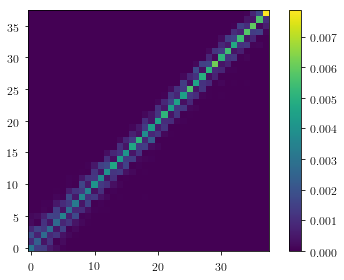

In [219]:
plt.imshow(response, origin='lower')
plt.colorbar()
plt.show()

In [220]:
# print('Loading data into memory...')
# df_data = comp.load_data(config=config,
#                          energy_reco=True,
#                          log_energy_min=6.1,
#                          log_energy_max=8.0,
#                          columns=feature_list + ['lap_ra', 'lap_dec'],
#                          n_jobs=20,
#                          verbose=True)

In [221]:
# df_data.to_hdf('data_dataframe.hdf', 'dataframe', format='table')

In [20]:
df_data = pd.read_hdf('data_dataframe.hdf', 'dataframe', mode='r')

In [21]:
df_data.shape

(6668215, 7)

In [22]:
energybins.log_energy_bins

array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ])

In [23]:
df_data.reco_log_energy.min(), df_data.reco_log_energy.max()

(6.100001266909608, 7.979532177403555)

In [267]:
print('Running energy reconstruction...')
for df in [df_data]:
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [268]:
df_data.reco_log_energy.min(), df_data.reco_log_energy.max()

(6.04731940764387, 9.659801452825425)

### Data declination distribution

In [262]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values

In [263]:
dec_median = df_data.loc[:, 'lap_dec'].median()
dec_median_deg = np.rad2deg(dec_median)

dec_median = -1.30927265203 [rad]
dec_median = -75.0157971934 [deg]


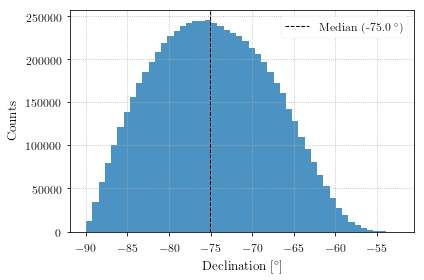

In [264]:
fig, ax = plt.subplots()
ax.hist(np.rad2deg(dec), bins=50, alpha=0.8)
print('dec_median = {} [rad]'.format(dec_median))
print('dec_median = {} [deg]'.format(dec_median_deg))
ax.axvline(dec_median_deg, marker='None', ls='--', lw=1, color='k',
           label='Median ({:0.1f}'.format(dec_median_deg)+' $^{\circ}$)')
# ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('Declination [$^{\circ}$]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'declination_hist.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

### Flux vs. declination 

In [226]:
import dask.array as da

X_data = da.from_array(df_data[feature_list].values, chunks=int(1e4))
X_data

dask.array<array, shape=(6668215, 3), dtype=float64, chunksize=(10000, 3)>

In [227]:
from dask_ml.wrappers import ParallelPostFit
from dask.diagnostics import ProgressBar

pred_comp_target = ParallelPostFit(comp_pipeline).predict(X_data)
reco_log_energy = ParallelPostFit(energy_pipeline).predict(X_data)

In [228]:
with ProgressBar():
#     print('Running energy reconstructions...')
#     df_data['reco_log_energy'] = reco_log_energy.compute(schuduler='threads', 
#                                                          num_workers=20)
    print('Running composition classifications...')
#     df_data['pred_comp_target'] = pred_comp_target.compute(schuduler='threads', 
#                                                            num_workers=20)
    df_data['pred_comp_target'] = pred_comp_target.compute()

Running composition classifications...
[#                                       ] | 3% Completed |  0.4s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##                                      ] | 5% Completed |  0.6s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###                                     ] | 7% Completed |  0.9s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###                                     ] | 8% Completed |  1.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[####                                    ] | 11% Completed |  1.2s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#####                                   ] | 14% Completed |  1.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#######                                 ] | 17% Completed |  1.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#######                                 ] | 18% Completed |  1.9s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[########                                ] | 21% Completed |  2.1s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#########                               ] | 23% Completed |  2.4s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##########                              ] | 26% Completed |  2.6s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###########                             ] | 28% Completed |  2.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[############                            ] | 30% Completed |  3.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#############                           ] | 33% Completed |  3.3s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##############                          ] | 35% Completed |  3.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##############                          ] | 37% Completed |  3.7s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###############                         ] | 39% Completed |  3.9s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[################                        ] | 41% Completed |  4.2s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#################                       ] | 43% Completed |  4.4s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##################                      ] | 45% Completed |  4.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##################                      ] | 46% Completed |  4.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###################                     ] | 48% Completed |  5.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[####################                    ] | 50% Completed |  5.2s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#####################                   ] | 52% Completed |  5.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[######################                  ] | 55% Completed |  5.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#######################                 ] | 59% Completed |  6.1s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[########################                ] | 60% Completed |  6.3s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[########################                ] | 62% Completed |  6.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#########################               ] | 64% Completed |  6.7s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##########################              ] | 67% Completed |  7.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###########################             ] | 68% Completed |  7.3s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[############################            ] | 70% Completed |  7.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#############################           ] | 72% Completed |  7.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##############################          ] | 75% Completed |  8.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###############################         ] | 77% Completed |  8.2s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###############################         ] | 79% Completed |  8.4s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[################################        ] | 81% Completed |  8.6s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[################################        ] | 82% Completed |  8.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#################################       ] | 84% Completed |  9.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##################################      ] | 86% Completed |  9.2s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[####################################    ] | 90% Completed |  9.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[####################################    ] | 91% Completed |  9.6s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#####################################   ] | 93% Completed |  9.9s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[######################################  ] | 95% Completed | 10.1s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[####################################### ] | 97% Completed | 10.4s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[########################################] | 100% Completed | 10.6s


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[########################################] | 100% Completed |  0.1s


In [32]:
# print('Running energy and composition reconstructions...')
# df_data['pred_comp_target'] = comp_pipeline.predict(df_data[feature_list].values)
# df_data['reco_log_energy'] = energy_pipeline.predict(df_data[feature_list].values)

In [269]:
# Effective area
eff_area, eff_area_err = {}, {}
for composition in comp_list+['total']:
    eff_area[composition] = df_eff['eff_median_{}'.format(composition)].values * thrown_area
    eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)].values * thrown_area
    
# Livetime
livetime, livetime_err = comp.get_detector_livetime(config=config)

In [270]:
df_eff['eff_median_total'].values

array([0.0067357 , 0.00768392, 0.00819213, 0.00845571, 0.00860106,
       0.00869518, 0.00876493, 0.00882504, 0.00888223, 0.00893701,
       0.00899151, 0.00904821, 0.00910125, 0.00915483, 0.00920796,
       0.00926119, 0.00931638, 0.00937015, 0.00942275])

In [271]:
np.rad2deg(np.arccos(df_data.lap_cos_zenith.max())), np.rad2deg(np.arccos(df_data.lap_cos_zenith.min()))

(0.0048982721856552, 37.65427444520522)

In [272]:
def calc_solid_angle(theta_min=0, theta_max=np.pi/2):
    return 2*np.pi*(np.cos(theta_min) - np.cos(theta_max))

def calc_geom_factor(theta_min=0, theta_max=np.pi/2):
    return (np.cos(theta_min) + np.cos(theta_max)) / 2

In [273]:
efficiencies

array([0.00711621, 0.00640114, 0.00792564, 0.00747336, 0.00837118,
       0.00800932, 0.00860879, 0.00827434, 0.00873487, 0.00842553,
       0.00880808, 0.00853552, 0.00885811, 0.00862577, 0.00889926,
       0.00871167, 0.00893319, 0.00879576, 0.00896376, 0.0088786 ,
       0.00899596, 0.00896131, 0.00902511, 0.00904439, 0.00905524,
       0.00912615, 0.00908302, 0.00920706, 0.00911336, 0.00928806,
       0.00914197, 0.00936856, 0.00917137, 0.00944958, 0.009201  ,
       0.00953194, 0.00922881, 0.00961275])

In [274]:
np.pi*np.sin(np.deg2rad(40))**2

1.2980304071610544

## Cosmic-ray flux vs. sky position

In [275]:
import sky_anisotropy as sa

In [276]:
nside = 64
npix = hp.nside2npix(nside)
radius = np.deg2rad(5)

In [277]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values
# Convert from ra/dec equatorial coordinates to the theta/phi coordinates used in healpy
theta, phi = comp.equatorial_to_healpy(ra, dec)

In [278]:
data_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

In [279]:
df_data['pix'] = pix_array

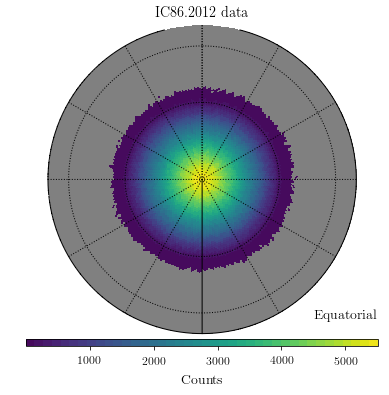

In [280]:
data_skymap[data_skymap == 0] = hp.UNSEEN
comp.plot_skymap(data_skymap, cbar_title='Counts', polar=True)
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-data-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [281]:
data_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

In [282]:
ra_test = np.deg2rad(0)
dec_test = np.deg2rad(-60)

n_pix_disc = 22045


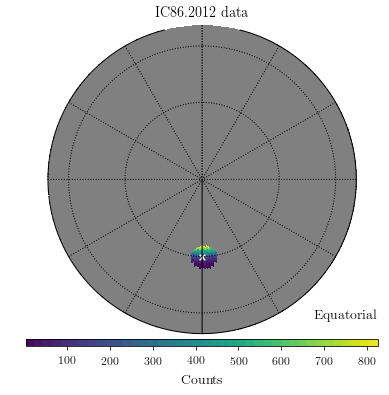

In [203]:
theta_test, phi_test = sa.equatorial_to_healpy(ra_test, dec_test)
vec_test = hp.ang2vec(theta_test, phi_test)
pix_center = hp.ang2pix(nside, theta_test, phi_test)

# ipix = hp.query_disc(nside, vec=vec, radius=radius)
# in_disc = np.isin(np.arange(npix), ipix)

# in_disc = sa.square_on_region(df_data['pix'], pix_center, size=np.deg2rad(5), nside=nside)
# n_pix_square = in_disc.sum()
in_disc = sa.disc_on_region(df_data['pix'], pix_center, size=np.deg2rad(5), nside=nside)
n_pix_disc = in_disc.sum()

print('n_pix_disc = {}'.format(n_pix_disc))
# print('n_pix_square = {}'.format(n_pix_square))
# print('n_pix_disc / n_pix_square = {}'.format(n_pix_disc / n_pix_square))

on_disc_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array[in_disc], return_counts=True)
on_disc_skymap[unique_pix] += pix_counts
# on_disc_skymap = data_skymap.copy()
# on_disc_skymap[~in_disc] = hp.UNSEEN

on_disc_skymap[on_disc_skymap == 0] = hp.UNSEEN
comp.plot_skymap(on_disc_skymap, cbar_title='Counts', polar=True)
hp.projscatter(theta_test, phi_test, color='w', marker='x')
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-on-disc-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [204]:
off_disc_skymap = data_skymap.copy()
off_disc_skymap[in_disc] = hp.UNSEEN

off_disc_skymap[off_disc_skymap == 0] = hp.UNSEEN
comp.plot_skymap(off_disc_skymap, cbar_title='Counts', polar=True)
hp.projscatter(theta_test, phi_test, color='w', marker='x')
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-off-disc-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 49152 but corresponding boolean dimension is 6668215

In [285]:
theta, phi = hp.pix2ang(nside, list(range(npix)))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# has_data = dec < df_data.loc[:, 'lap_dec'].max()

dec_max_deg = -60
# dec_max_deg = -80
# dec_max_deg = -88
print('dec_max_deg = {}'.format(dec_max_deg))

size = np.deg2rad(5)
print('size = {:0.2f} [deg]'.format(np.rad2deg(size)))

ebins = np.arange(6.4, 7.9, 0.1)
# ebins = np.arange(6.4, 7.5, 0.1)
# ebins = np.concatenate([ebins, [7.8]])

on_region = 'disc'
# on_region = 'square'
print('on_region = {}'.format(on_region))

# off_region = 'allsky'
off_region = 'theta_band'
# off_region = 'opposite'
print('off_region = {}'.format(off_region))

# key = 'log_s125'
key = 'reco_log_energy'
print('key = {}'.format(key))

has_data = dec < np.deg2rad(dec_max_deg)
if off_region == 'theta_band':
    has_data = has_data & (dec > np.deg2rad(-90) + size)

has_data.sum()

dec_max_deg = -60
size = 5.00 [deg]


3280

In [286]:
energy_range_mask = (df_data['reco_log_energy'] >= 6.1) & (df_data['reco_log_energy'] <= 8.0)

In [76]:
dec_bins = np.deg2rad(np.linspace(-90, -50, 3, endpoint=True))
dec_bins

array([-1.57079633, -1.22173048, -0.87266463])

In [158]:
eff = np.load('efficienies.npy')
eff_err = np.load('efficienies_err.npy')
eff.reshape(-1)

array([0.00711648, 0.00639353, 0.00792472, 0.00747015, 0.00837055,
       0.00800534, 0.00860573, 0.00827011, 0.00873291, 0.00842231,
       0.00880792, 0.00853085, 0.0088584 , 0.00862292, 0.00889751,
       0.00870882, 0.00893136, 0.00879243, 0.00896279, 0.00887518,
       0.0089931 , 0.00895761, 0.00902289, 0.00903992, 0.00905245,
       0.00912219, 0.0090819 , 0.00920444, 0.0091113 , 0.00928668,
       0.00914067, 0.00936892, 0.00917003, 0.00945116, 0.00919939,
       0.0095334 , 0.00922875, 0.00961564])

In [164]:
response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                              reco_energy=log_reco_energy_sim_test,
                                              true_target=true_target,
                                              pred_target=pred_target,
                                              efficiencies=eff.reshape(-1),
                                              efficiencies_err=eff_err.reshape(-1),
                                              energy_bins=energybins.log_energy_bins)

In [165]:
np.testing.assert_allclose(response.sum(axis=0), eff.reshape(-1))

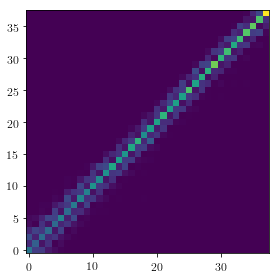

In [166]:
plt.imshow(response, origin='lower')

In [52]:
unfolding_energy_range_mask = np.logical_and(energybins.log_energy_midpoints >= 6.4,
                                             energybins.log_energy_midpoints <= 7.8)

In [54]:
def unfolding_func(counts):
    original_shape = counts.shape
    counts_err = np.sqrt(counts)
    unfolded_results = pyunfold.iterative_unfold(data=counts.reshape(-1),
                                                 data_err=counts_err.reshape(-1),
                                                 response=response,
                                                 response_err=response_err,
                                                 efficiencies=efficiencies.reshape(-1),
                                                 efficiencies_err=efficiencies_err.reshape(-1),
                                                 ts='ks',
                                                 ts_stopping=0.01,
                                                 return_iterations=True,
#                                                  callbacks=pyunfold.Logger()
                                                )
#     print(unfolded_results)
#     unfolded = unfolded_results['unfolded']
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolded_results,
                                                                        num_groups=num_groups)
#     print(unfolded.reshape(original_shape)[unfolding_energy_range_mask])
#     return unfolded.reshape(original_shape)[unfolding_energy_range_mask].sum(axis=1)

    eff_total = df_eff['eff_median_total'].values[unfolding_energy_range_mask]
    
    counts = counts['total'][unfolding_energy_range_mask] / eff_total
    counts_err = counts_sys_err['total'][unfolding_energy_range_mask] / eff_total

    return counts, counts_err

In [57]:
energy_comp_bins = comp.get_bins(config=config, num_groups=2)
# energy_comp_bins[0] = energy_comp_bins[0][3:-2]
energy_comp_bins

[array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
        7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ]), array([0, 1, 2])]

In [92]:
c, _ = np.histogramdd(df_data.loc[:, ['reco_log_energy', 'pred_comp_target']].values, bins=energy_comp_bins)
c

array([[9.44957e+05, 7.51526e+05],
       [8.77673e+05, 6.99730e+05],
       [6.05615e+05, 5.26746e+05],
       [4.35386e+05, 3.43818e+05],
       [2.96770e+05, 2.19852e+05],
       [1.96104e+05, 1.37759e+05],
       [1.10422e+05, 9.93680e+04],
       [7.20010e+04, 5.71130e+04],
       [4.36660e+04, 3.45300e+04],
       [2.20760e+04, 2.50400e+04],
       [1.44320e+04, 1.44290e+04],
       [7.83900e+03, 9.94300e+03],
       [4.49200e+03, 6.75100e+03],
       [2.77700e+03, 4.31500e+03],
       [1.65400e+03, 2.98600e+03],
       [8.65000e+02, 2.03900e+03],
       [5.31000e+02, 1.29000e+03],
       [3.62000e+02, 7.95000e+02],
       [2.03000e+02, 5.99000e+02]])

In [99]:
c_shape = c.shape
unfolded_results = pyunfold.iterative_unfold(data=c.reshape(-1),
                                             data_err=c.reshape(-1),
                                             response=response,
                                             response_err=response_err,
                                             efficiencies=efficiencies.reshape(-1),
                                             efficiencies_err=efficiencies_err.reshape(-1),
                                             ts='ks',
                                             ts_stopping=0.01,
                                             return_iterations=True,
                                             callbacks=pyunfold.Logger())

Iteration 1: ts = 0.6100, ts_stopping = 0.01
Iteration 2: ts = 0.0444, ts_stopping = 0.01
Iteration 3: ts = 0.0162, ts_stopping = 0.01
Iteration 4: ts = 0.0097, ts_stopping = 0.01


In [100]:
unfolded_results

,num_iterations,stat_err,sys_err,ts_iter,ts_stopping,unfolded
0,1,"[72144060.5539402, 65263651.468855485, 4939159...","[9260598.502860475, 9260451.954531727, 6047797...",0.609956,0.01,"[122256006.86924757, 118236547.14915477, 10095..."
1,2,"[110172338.16200663, 96591482.34649698, 649492...","[14540329.181402853, 14505296.89321703, 831131...",0.044443,0.01,"[141462877.96656603, 133608476.85272926, 10694..."
2,3,"[136007465.61649355, 119147582.6842352, 788618...","[18470628.938835535, 18451994.46890841, 101028...",0.016188,0.01,"[149952668.24413016, 139399778.8103174, 107243..."
3,4,"[157758072.15801272, 139035507.63523868, 91851...","[21756871.75994542, 21806682.48076413, 1175591...",0.009716,0.01,"[155105714.47073385, 142780131.99427956, 10656..."


In [101]:
counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolded_results,
                                                                    num_groups=num_groups)
counts

{'heavy': array([1.42780132e+08, 8.19576562e+07, 5.01552462e+07, 3.48210577e+07,
        2.33715443e+07, 1.41525433e+07, 9.05747716e+06, 6.18954766e+06,
        3.73280514e+06, 2.38509106e+06, 1.65700170e+06, 1.02448150e+06,
        7.24417517e+05, 5.11601409e+05, 3.01854100e+05, 2.32379029e+05,
        1.27258209e+05, 9.47463201e+04, 5.77088332e+04]),
 'light': array([1.55105714e+08, 1.06566543e+08, 7.64276121e+07, 5.05317203e+07,
        3.49518159e+07, 2.21007515e+07, 1.37153312e+07, 7.84634774e+06,
        4.89284370e+06, 2.64138672e+06, 1.57388165e+06, 8.38666820e+05,
        4.26289476e+05, 2.82155681e+05, 1.76665236e+05, 9.31184983e+04,
        4.67541565e+04, 2.71273641e+04, 1.92186823e+04]),
 'total': array([2.97885846e+08, 1.88524199e+08, 1.26582858e+08, 8.53527781e+07,
        5.83233602e+07, 3.62532948e+07, 2.27728084e+07, 1.40358954e+07,
        8.62564883e+06, 5.02647778e+06, 3.23088335e+06, 1.86314832e+06,
        1.15070699e+06, 7.93757091e+05, 4.78519337e+05, 3.2549752

In [204]:
def counts_to_flux(counts, counts_err=None, composition=None):
    return comp.get_flux(counts, counts_err,
                         energybins=energybins.energy_bins,
                         eff_area=thrown_area,
#                          eff_area=geom_factor * thrown_area,
                         eff_area_err=None,                            
#                              eff_area=geom_factor * eff_area[composition],
#                              eff_area_err=geom_factor * eff_area_err[composition],
                         livetime=livetime,
                         livetime_err=livetime_err,
                         solid_angle=solid_angle,
                         scalingindex=2.7)

In [221]:
unfolded_err = unfolded_results['stat_err'].reshape(c_shape)
unfolded_err

array([[1.91785034e+08, 1.64363918e+08],
       [9.65102288e+07, 7.62024645e+07],
       [7.83126921e+07, 5.66765975e+07],
       [5.27301723e+07, 3.88060493e+07],
       [4.16657475e+07, 2.74987447e+07],
       [2.77989062e+07, 1.81228861e+07],
       [1.62761629e+07, 1.26755588e+07],
       [1.00017004e+07, 7.95538018e+06],
       [6.55718913e+06, 5.35622026e+06],
       [2.92628875e+06, 3.17312300e+06],
       [2.03729344e+06, 2.19840475e+06],
       [1.02733366e+06, 1.35067847e+06],
       [5.64279443e+05, 1.01004526e+06],
       [3.47550012e+05, 6.64206744e+05],
       [2.40858616e+05, 4.52939795e+05],
       [1.19665254e+05, 3.17960126e+05],
       [6.88879301e+04, 1.92893427e+05],
       [3.36896519e+04, 1.19889391e+05],
       [3.55206632e+04, 2.08913471e+05]])

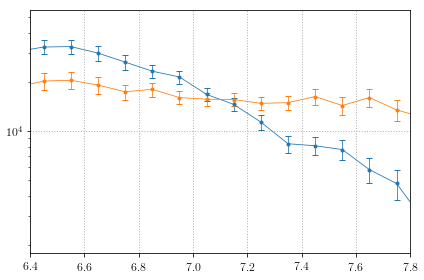

In [218]:
fig, ax = plt.subplots()
unfolded = unfolded_results['unfolded'].reshape(c_shape)
unfolded_err = unfolded_results['sys_err'].reshape(c_shape)
for comp_idx, composition in enumerate(comp_list):
    counts = unfolded[:, comp_idx]
    counts_err = unfolded_err[:, comp_idx]
    flux, flux_err = counts_to_flux(counts, counts_err)
    plt.errorbar(energybins.log_energy_midpoints,
                 flux,
                 yerr=flux_err,
                 color=color_dict[composition])
    
# counts_total = unfolded.sum(axis=1)

# plt.errorbar(energybins.log_energy_midpoints[unfolding_energy_range_mask],
#              unfolded[unfolding_energy_range_mask, :].sum(axis=1), 
#              yerr=unfolded_err[unfolding_energy_range_mask, :].sum(axis=1),
#              color=color_dict['total'])

ax.set_yscale('log', nonposy='clip')
ax.set_xlim(6.4, 7.8)
ax.grid()
plt.show()

In [104]:
pix_max_sig

48845

In [61]:
sa.core.on_off_chi_squared_single(samples=df_data.loc[energy_range_mask, ['reco_log_energy', 'pred_comp_target']].values,
                                  pix=df_data.loc[energy_range_mask, 'pix'].values,
                                  pix_center=pix_disc[0],
                                  on_region=on_region,
                                  size=size,
                                  off_region=off_region,
                                  bins=energy_comp_bins,
                                  nside=nside,
                                  hist_func=unfolding_func)

NameError: name 'pix_disc' is not defined

In [64]:
from sky_anisotropy.core import on_off_chi_squared_single

counts_on_test, counts_on_err_test, counts_off_test, counts_off_err_test = sa.on_off_distributions(
                          samples=df_data.loc[energy_range_mask, ['reco_log_energy', 'pred_comp_target']].values,
                          pix=df_data.loc[energy_range_mask, 'pix'].values,
                          pix_center=pix_disc[0],
                          on_region=on_region,
                          size=size,
                          off_region=off_region,
                          bins=energy_comp_bins,
                          nside=nside,
                          hist_func=unfolding_func)
#                           hist_func=hist_func)

In [65]:
counts_on_test.shape

(14,)

In [66]:
energy_comp_bins[0][:-1].shape

(19,)

In [67]:
counts_on_test.shape

(14,)

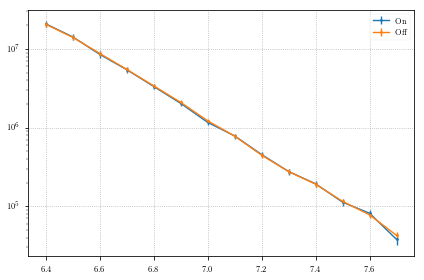

In [70]:
unfolded_counts_on_test = counts_on_test
unfolded_counts_on_err_test = counts_on_err_test
unfolded_counts_off_test = counts_off_test
unfolded_counts_off_err_test = counts_off_err_test

alpha = np.sum(unfolded_counts_on_test) / np.sum(unfolded_counts_off_test)
scaled_unfolded_counts_off_test = alpha * unfolded_counts_off_test
scaled_unfolded_counts_off_err_test = alpha * unfolded_counts_off_err_test

fig, ax = plt.subplots()
ax.errorbar(energy_comp_bins[0][:-1][unfolding_energy_range_mask],
            unfolded_counts_on_test,
            unfolded_counts_on_err_test,
            label='On',
            color='C0')
ax.errorbar(energy_comp_bins[0][:-1][unfolding_energy_range_mask],
            scaled_unfolded_counts_off_test,
            scaled_unfolded_counts_off_err_test,
            label='Off',
            color='C1')
# comp.plot_steps(energy_comp_bins[0][unfolding_energy_range_mask], scaled_counts_off_test, np.sqrt(scaled_counts_off_test), label='Off', color='C1', ax=ax)
ax.set_yscale('log', nonposy='clip')
ax.grid()
ax.legend()
plt.show()

In [139]:
sa.core.counts_chi_squared(unfolded_counts_on_test, scaled_unfolded_counts_off_test)

2314.8055282815576

In [288]:
pix_disc = np.arange(npix)[has_data]
pix_disc.shape

(3280,)

In [289]:
num_workers = min(len(pix_disc), 35)
with dask.config.set(scheduler='threads', num_workers=num_workers) as _, ProgressBar() as pbar:
    samples = df_data.loc[:, [key]].values
    pix = df_data.loc[:, 'pix'].values
    results = sa.on_off_chi_squared(
#                                     samples=df_data.loc[:, ['reco_log_energy', 'pred_comp_target']].values,
                                    samples=samples,
                                    pix=pix,
                                    pix_center=pix_disc,
                                    on_region=on_region,
                                    size=size,
                                    off_region=off_region,
                                    bins=ebins, 
#                                     bins=energy_comp_bins,
                                    nside=nside,
#                                     hist_func=unfolding_func,
                                    )

[########################################] | 100% Completed | 17min  1.7s
[########################################] | 100% Completed |  0.1s


In [290]:
results.head()

,alpha,chi2,ndof,num_on,pix_center,pval,sig
0,0.045728,10.936058,14,11754.0,45872,0.691052,-0.498834
1,0.046914,16.705447,14,12045.0,45873,0.272215,0.606129
2,0.048801,15.507857,14,12507.0,45874,0.344342,0.400640
3,0.048662,18.524282,14,12473.0,45875,0.183935,0.900472
4,0.046649,21.149866,14,11980.0,45876,0.097853,1.293881


In [291]:
output_hdf = os.path.join(os.getcwd(),
                          'results',
                          '{}_energy'.format(energy_pipeline_name),
                          'chi2-results-{}-on-{}-off-{:0.0f}deg-size.hdf'.format(on_region, off_region, np.rad2deg(size)))
print('output_hdf = {}'.format(output_hdf))
comp.check_output_dir(output_hdf)
results.to_hdf(output_hdf, 'dataframe', format='table')

output_hdf = /home/jbourbeau/cr-composition/skymap/results/linearregression_energy/chi2-results-disc-on-theta_band-off-5deg-size.hdf


In [245]:
# input_hdf = os.path.join(os.getcwd(), 'data', 'chi2-results-radius-{:0.1f}-degree.hdf'.format(np.rad2deg(radius)))
# input_hdf = os.path.join(os.getcwd(),
#                          'results',
#                          key,
#                          'chi2-results-{}-on-{}-off-{:0.0f}deg-size.hdf'.format(on_region, off_region, np.rad2deg(size)))
# results = pd.read_hdf(input_hdf)

In [292]:
from scipy import stats

In [293]:
theta_center, phi_center = hp.pix2ang(nside=nside, ipix=results['pix_center'].values)
ra_center, dec_center = sa.healpy_to_equatorial(theta_center, phi_center)
dec_center

array([-1.05477994, -1.05477994, -1.05477994, ..., -1.55803848,
       -1.55803848, -1.55803848])

In [294]:
dec_mask = dec_center < np.deg2rad(-65)
dec_mask

array([False, False, False, ...,  True,  True,  True])

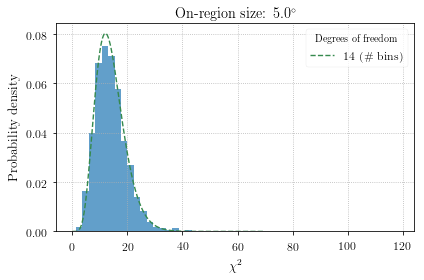

In [308]:
fig, ax = plt.subplots()
hist_params = {'bins': 50,
#                'histtype': 'step',
               'alpha': 0.7,
               }
ax.hist(results.loc[:, 'chi2'].values, density=True, **hist_params)
# ax.hist(results.loc[dec_mask, 'chi2'].values, density=True, **hist_params)

# Include chi-squared PDF for various degrees of freedom
x = np.linspace(0, 70, 200)
num_bins = len(ebins) - 1
for dof, label, color, ls in zip([num_bins - 1, num_bins, num_bins + 1, num_bins + 2],
                                 ['\# bins - 1', '\# bins', '\# bins + 1', '\# bins + 2'],
                                 sns.color_palette('Greens_d', 4).as_hex(),
                                 ['-', '--', '-.', ':']):
    
    if dof != num_bins:
        continue

    chi2_pdf = stats.chi2.pdf(x, dof)
    ax.plot(x, chi2_pdf,
            marker='None',
            ls=ls,
            color=color,
            label='{} ({})'.format(dof, label))

ax.set_xlabel('$\\chi^2$')
ax.set_ylabel('Probability density')
ax.set_title('On-region size: {:0.1f}'.format(np.rad2deg(size)) + '$^{\circ}$')
ax.grid()
ax.legend(title='Degrees of freedom')

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-chi2-calc-comparison.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

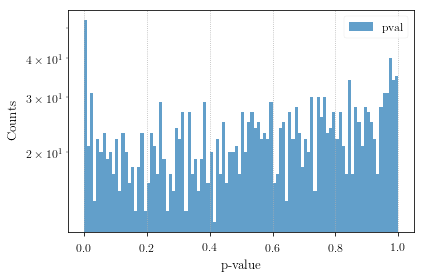

In [296]:
fig, ax = plt.subplots()
hist_params = {'bins': 100,
#                'histtype': 'step',
               'alpha': 0.7,
               }
ax.hist(results.loc[dec_mask, 'pval'], **hist_params)
ax.set_xlabel('p-value')
ax.set_ylabel('Counts')
ax.set_yscale('log', nonposy='clip')
ax.grid()
ax.legend()

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-pval-hist.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

-0.6059968059615833


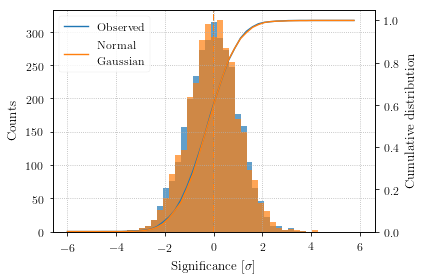

In [297]:
from scipy.special import erfcinv

fig, ax = plt.subplots()
bins = np.linspace(-6, 6, 50)
hist_params = {'bins': bins,
#                'histtype': 'step',
               'alpha': 0.7,
               }

theta, phi = hp.pix2ang(nside, results['pix_center'])
ra, dec = sa.healpy_to_equatorial(theta, phi)

# sig = results.loc[:, 'sig']
sig = results.loc[dec > np.deg2rad(-90) + size, 'sig']

ax.hist(sig, **hist_params)
ax.axvline(sig.median(),
           marker='None', ls='-.', lw=1,
           label='Median')

counts, _ = np.histogram(sig, bins=bins)
counts = counts / counts.sum()
ax_cdf = ax.twinx()
ax_cdf.plot(bins[:-1], np.cumsum(counts), marker='None',
            label='Observed')
ax_cdf.set_ylabel('Cumulative distribution')
ax_cdf.set_ylim(bottom=0)

np.random.seed(2)
# normal_samples = np.random.normal(size=int(1e6))
normal_samples = np.random.normal(size=len(sig))
ax.axvline(np.median(normal_samples),
           marker='None', ls='-.', lw=1,
           label='Median', color='C1')
ax.hist(normal_samples, **hist_params)
counts, _ = np.histogram(normal_samples, bins=bins)
counts = counts / counts.sum()
ax_cdf.plot(bins[:-1], np.cumsum(counts), marker='None',
            label='Normal \n Gaussian' )


d, ks_pval = stats.ks_2samp(normal_samples, sig.values)
print(erfcinv(2 * ks_pval) * np.sqrt(2))


ax.set_xlabel('Significance [$\\sigma$]')
ax.set_ylabel('Counts')
ax.grid()
ax_cdf.legend()

# outfile = os.path.join(comp.paths.figures_dir,
#                        'skymaps',
#                        'radius-{}-degrees'.format(np.rad2deg(size)),
#                        '{}-significance-dist.png'.format(config))

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                        '{}-significance-dist.png'.format(config))
plt.savefig(outfile)

plt.show()

Save map to disk

In [298]:
# hp.write_map('chi-squared-map.fits', chi2_map, dtype=chi2_map.dtype, coord='C')

In [299]:
# chi2_map = hp.read_map('chi-squared-map.fits')

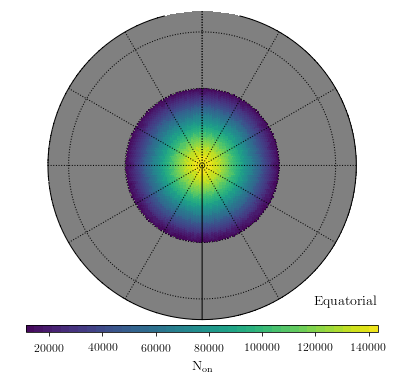

In [300]:
num_on_map = np.full(npix, hp.UNSEEN)
# chi2_map = np.zeros(npix)
# chi2_map[pix_idxs] = chi_squared
num_on_map[results['pix_center']] = results['num_on']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# num_on_map[dec < np.deg2rad(-90) + size] = hp.UNSEEN

comp.plot_skymap(num_on_map, cbar_title='$\mathrm{N_{on}}$', polar=True)
# theta, phi = hp.pix2ang(nside=nside, ipix=pix_idxs)
# hp.projscatter(theta, phi, c=chi2)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'radius-{}-degrees'.format(np.rad2deg(size)),
                       '{}-num-on-skymap-polar.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

In [304]:
1

1

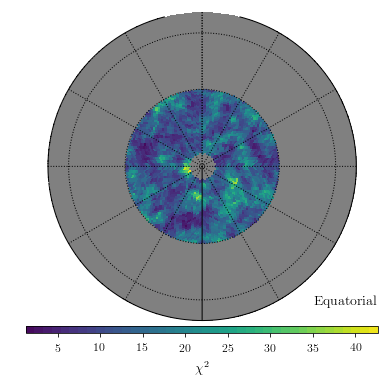

In [305]:
chi2_map = np.full(npix, hp.UNSEEN)
# chi2_map = np.zeros(npix)
# chi2_map[pix_idxs] = chi_squared
chi2_map[results['pix_center']] = results['chi2']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# chi2_map[dec > np.deg2rad(-65)] = hp.UNSEEN
if off_region == 'theta_band':
    chi2_map[dec < np.deg2rad(-90) + size] = hp.UNSEEN

comp.plot_skymap(chi2_map, cbar_title='$\mathrm{\chi^2}$', polar=True)
# theta, phi = hp.pix2ang(nside=nside, ipix=pix_idxs)
# hp.projscatter(theta, phi, c=chi2)

# outfile = os.path.join(comp.paths.figures_dir,
#                        'skymaps',
#                        'radius-{}-degrees'.format(np.rad2deg(size)),
#                        '{}-chi2-skymap-polar.png'.format(config))

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-chi2-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


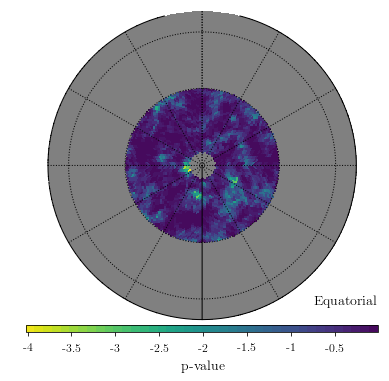

In [306]:
pval_map = np.full(npix, hp.UNSEEN)
pval_map[results['pix_center']] = results['pval']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# pval_map[dec > np.deg2rad(-65)] = hp.UNSEEN
if off_region == 'theta_band':
    pval_map[dec < np.deg2rad(-90) + size] = hp.UNSEEN

comp.plot_skymap(np.log10(pval_map), cbar_title='p-value', polar=True, color_palette='viridis_r')
# comp.plot_skymap(pval_map, cbar_title='p-value', polar=True, color_palette='viridis_r')

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-pval-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

In [324]:
results.head()

,alpha,chi2,ndof,num_on,pix_center,pval,sig
0,0.045728,10.936058,14,11754.0,45872,0.691052,-0.498834
1,0.046914,16.705447,14,12045.0,45873,0.272215,0.606129
2,0.048801,15.507857,14,12507.0,45874,0.344342,0.400640
3,0.048662,18.524282,14,12473.0,45875,0.183935,0.900472
4,0.046649,21.149866,14,11980.0,45876,0.097853,1.293881


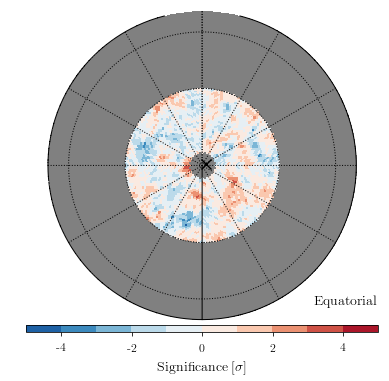

In [310]:
sig_map = np.full(npix, hp.UNSEEN)
sig_map[results['pix_center']] = results['sig']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# sig_map[dec > np.deg2rad(-65)] = hp.UNSEEN
if off_region == 'theta_band':
    sig_map[dec < np.deg2rad(-90) + size] = hp.UNSEEN

comp.plot_skymap(sig_map,
                 color_palette='RdBu_r',
                 cbar_min=-5,
                 cbar_max=5,
                 color_bins=10,
                 cbar_title='Significance [$\sigma$]',
                 polar=True)

results_filtered = results

pix_max_sig = results.loc[results.sig.idxmax(), 'pix_center']
theta_max, phi_max = hp.pix2ang(nside=nside, ipix=pix_max_sig)

hp.projscatter(theta_max, phi_max, marker='x', s=100, c='k')

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-sig-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

In [311]:
results.loc[dec_mask, 'sig'].min(), results.loc[dec_mask, 'sig'].max()

(-4.426431973449318, 8.720315967293415)

In [312]:
pix_max_sig = results.loc[results.sig.idxmax(), 'pix_center']
theta_max, phi_max = hp.pix2ang(nside=nside, ipix=pix_max_sig)


samples = df_data.loc[:, [key]].values
pix = df_data.loc[:, 'pix'].values
counts_on_max, counts_on_err_max, counts_off_max, counts_off_err_max = sa.on_off_distributions(samples=samples,
                                pix=pix,
                                pix_center=pix_max_sig,
                                on_region=on_region,
                                size=size,
                                off_region=off_region,
                                bins=ebins, 
                                nside=nside)

In [313]:
ebins_midpoints = (ebins[:-1] + ebins[1:]) / 2
ebins_midpoints

array([6.45, 6.55, 6.65, 6.75, 6.85, 6.95, 7.05, 7.15, 7.25, 7.35, 7.45,
       7.55, 7.65, 7.75])

In [314]:
ebins

array([6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6,
       7.7, 7.8])

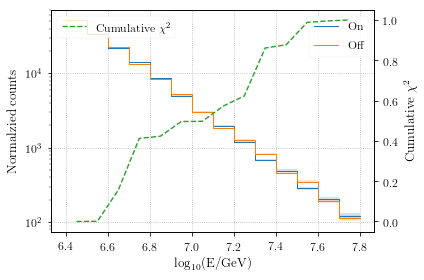

In [315]:
alpha = np.sum(counts_on_max) / np.sum(counts_off_max)
scaled_counts_off_max = alpha * counts_off_max

fig, ax = plt.subplots()
comp.plot_steps(ebins, counts_on_max, np.sqrt(counts_on_max), label='On', color='C0', ax=ax)
comp.plot_steps(ebins, scaled_counts_off_max, np.sqrt(scaled_counts_off_max), label='Off', color='C1', ax=ax)

chi2_max = results.loc[results.sig.idxmax(), 'chi2']
cumulative_chi2 = []
for stop_idx in range(1, len(counts_on_max) + 1):
    # stop_idx = -4
    c = sa.core.counts_chi_squared(counts_on_max[:stop_idx],
                                   scaled_counts_off_max[:stop_idx] * (counts_on_max[:stop_idx].sum() / scaled_counts_off_max[:stop_idx].sum())
                                  )
    cumulative_chi2.append(c / chi2_max)
    
ax2 = ax.twinx()
ax2.plot(ebins_midpoints, cumulative_chi2,
         marker='None',
         ls='--',
         color='C2',
         label='Cumulative $\mathrm{\chi^2}$')
ax2.set_ylabel('Cumulative $\mathrm{\chi^2}$')
ax2.legend()

ax.set_ylabel('Normalzied counts')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_yscale('log', nonposy='clip')
ax.grid()
ax.legend()

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-max-sig-energy-dist.png'.format(config))
plt.savefig(outfile)

plt.show()

In [316]:
results.chi2.max()

118.24540350172661

In [80]:
sa.core.counts_chi_squared(counts_on_max, scaled_counts_off_max)

75.16138679532881

In [148]:
ebins_midpoints.shape, len(cumulative_chi2)

((14,), 13)

In [149]:
cumulative_chi2 = []
for stop_idx in range(1, len(counts_on_max) + 1):
    # stop_idx = -4
    c = sa.core.counts_chi_squared(counts_on_max[:stop_idx],
                                   scaled_counts_off_max[:stop_idx] * (counts_on_max[:stop_idx].sum() / scaled_counts_off_max[:stop_idx].sum())
                                  )
    cumulative_chi2.append(c)

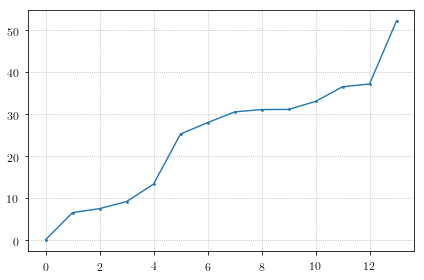

In [150]:
plt.plot(cumulative_chi2)
plt.grid()
plt.show()

In [127]:
for r in [3.0, 4.0, 5.0]:
    input_hdf = os.path.join(os.getcwd(), 'data', 'chi2-results-radius-{:0.1f}-degree.hdf'.format(r))
    results = pd.read_hdf(input_hdf)

    sig_map = np.full(npix, hp.UNSEEN)
    sig_map[results['pix_disc']] = results['sig']

    theta, phi = hp.pix2ang(nside, range(npix))
    ra, dec = healpy_to_equatorial(theta, phi)
    sig_map[dec < np.deg2rad(-90) + np.deg2rad(r)] = hp.UNSEEN

    comp.plot_skymap(sig_map,
                     color_palette='RdBu_r',
                     cbar_min=-5, cbar_max=5,
                     cbar_title='Significance [$\sigma$]',
                     polar=True)

    outfile = os.path.join(comp.paths.figures_dir,
                           'skymaps',
                           'radius-{}-degrees'.format(r),
                           '{}-sig-skymap-polar.png'.format(config))
    plt.savefig(outfile)

    plt.show()

NameError: name 'healpy_to_equatorial' is not defined

In [245]:
sig_map.max()

5.005907156818285

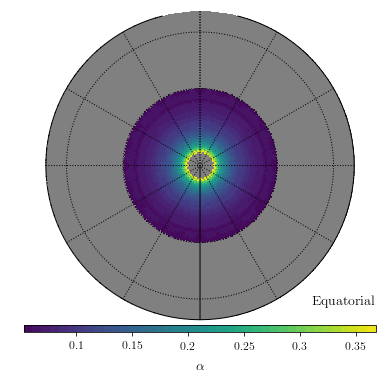

In [246]:
alpha_map = np.full(npix, hp.UNSEEN)
alpha_map[results['pix_disc']] = results['alpha']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = healpy_to_equatorial(theta, phi)
alpha_map[dec < np.deg2rad(-90) + radius] = hp.UNSEEN

comp.plot_skymap(alpha_map, cbar_title='$\mathrm{\\alpha}$', polar=True)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-alpha-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

In [87]:
energy_mask = df_data.loc[:, 'reco_log_energy'] > 7.9
energy = df_data.loc[energy_mask, 'reco_log_energy']
ra = df_data.loc[energy_mask, 'lap_ra']
dec = df_data.loc[energy_mask, 'lap_dec']

theta, phi = equatorial_to_healpy(ra, dec)

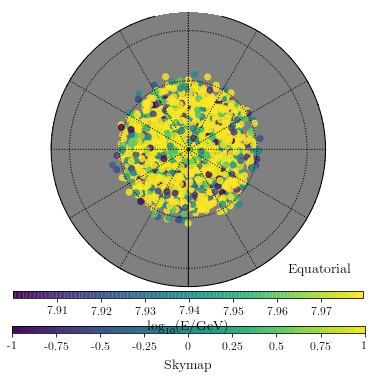

In [103]:
comp.plot_skymap(np.full(npix, hp.UNSEEN), polar=True)
fig = plt.gcf()
ax = plt.gca()

image = hp.projscatter(theta, phi, c=energy, alpha=0.8)
cbar = fig.colorbar(image,
                    orientation='horizontal',
                    aspect=50,
                    pad=0.01,
                    fraction=0.1,
                    ax=ax,
                    format=FormatStrFormatter('%g'),
                    shrink=1.0)
cbar.set_label('$\mathrm{\log_{10}(E/GeV)}$', size=14)
plt.show()